# Feature Engineering + Baseline de Modelado

## Cargar dataset limpio

In [1]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

DATA_PATH = Path("../data/processed/suicides_clean.csv")
df = pd.read_csv(DATA_PATH)

print(df.shape)
df.head()


(32316, 7)


,country,year,sex,age,suicides_no,population,suicides_100k_pop
0,Albania,1987,female,15-24 years,14,289700,4.832585
1,Albania,1987,female,25-34 years,4,257200,1.555210
2,Albania,1987,female,35-54 years,6,278800,2.152080
3,Albania,1987,female,5-14 years,0,311000,0.000000
4,Albania,1987,female,55-74 years,0,144600,0.000000





## Feature Engineering

Elegimos features que pueden explicar la tasa de suicidios:

* **Categorías → dummies**:

  * `country` (o mejor, agrupar por región primero para reducir cardinalidad).
  * `sex`, `age`.
* **Numéricas**:

  * `year` (se puede tratar como continuo o usar tendencias).
  
* **Target**:

  * `suicides_100k_pop`.



In [2]:
# Features & target
X = df[["country", "sex", "age", "year"]]
y = df["suicides_100k_pop"]

# One-hot encoding
X_enc = pd.get_dummies(X, columns=["country", "sex", "age"], drop_first=True)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.2, random_state=42
)

## 🌳 Random Forest

In [3]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest")
print(" MAE:", mean_absolute_error(y_test, y_pred_rf))
print(" RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print(" R²:", r2_score(y_test, y_pred_rf))


Random Forest
 MAE: 2.7081058067370343
 RMSE: 6.566054354016383
 R²: 0.8868704904676227


## ⚡ Gradient Boosting

In [4]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(random_state=42)
hgb.fit(X_train, y_train)
y_pred_hgb = hgb.predict(X_test)

print("HistGradientBoosting")
print(" MAE:", mean_absolute_error(y_test, y_pred_hgb))
print(" RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_hgb)))
print(" R²:", r2_score(y_test, y_pred_hgb))


HistGradientBoosting
 MAE: 4.7322354265743485
 RMSE: 8.398899516208399
 R²: 0.8148977371007352


## 🔥 XGBoost

In [5]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost")
print(" MAE:", mean_absolute_error(y_test, y_pred_xgb))
print(" RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print(" R²:", r2_score(y_test, y_pred_xgb))


XGBoost
 MAE: 4.293156623075441
 RMSE: 7.522451749475098
 R²: 0.851513907466697


## Comparación

In [6]:
results = pd.DataFrame([
    ["RandomForest", mean_absolute_error(y_test, y_pred_rf), np.sqrt(mean_squared_error(y_test, y_pred_rf)), r2_score(y_test, y_pred_rf)],
    ["HistGradientBoosting", mean_absolute_error(y_test, y_pred_hgb), np.sqrt(mean_squared_error(y_test, y_pred_hgb)), r2_score(y_test, y_pred_hgb)],
    ["XGBoost", mean_absolute_error(y_test, y_pred_xgb), np.sqrt(mean_squared_error(y_test, y_pred_xgb)), r2_score(y_test, y_pred_xgb)],
], columns=["Modelo", "MAE", "RMSE", "R2"])

print(results)


                 Modelo       MAE      RMSE        R2
0          RandomForest  2.708106  6.566054  0.886870
1  HistGradientBoosting  4.732235  8.398900  0.814898
2               XGBoost  4.293157  7.522452  0.851514


👉 RandomForest es el mejor modelo de los tres:

* Error medio bajo (2.7 suicidios por cada 100k hab).
* Muy buena capacidad explicativa (casi 89% de la varianza explicada).
* Probablemente captura bien la no linealidad.

Observemos que tan bien se comporta el modelo RandomForest

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicciones en train
y_pred_train = rf.predict(X_train)

print("Random Forest - Train")
print(" MAE:", mean_absolute_error(y_train, y_pred_train))
print(" RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print(" R²:", r2_score(y_train, y_pred_train))

# Ya tenías las de test:
y_pred_test = rf.predict(X_test)
print("\nRandom Forest - Test")
print(" MAE:", mean_absolute_error(y_test, y_pred_test))
print(" RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print(" R²:", r2_score(y_test, y_pred_test))


Random Forest - Train
 MAE: 1.0060436299466848
 RMSE: 2.5455053574679605
 R²: 0.983223292397364

Random Forest - Test
 MAE: 2.7081058067370343
 RMSE: 6.566054354016383
 R²: 0.8868704904676227


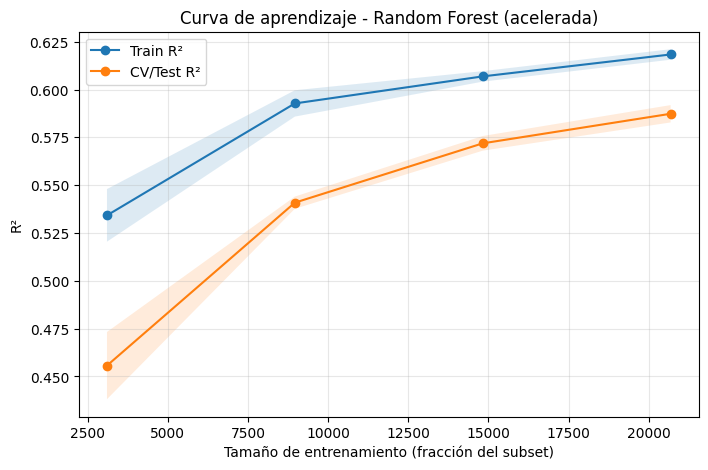

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor

# (Opcional) usar un subconjunto para la curva (acelera muchísimo)
use_subset = True
subset_frac = 0.8  # 35% de filas
if use_subset:
    import pandas as pd
    X_lc = X_enc.sample(frac=subset_frac, random_state=42)
    y_lc = y.loc[X_lc.index]
else:
    X_lc, y_lc = X_enc, y

# Modelo más "barato" sólo para la curva
rf_lc = RandomForestRegressor(
    n_estimators=500,      # antes 500
    max_depth=14,         # limita complejidad
    min_samples_leaf=3,   # regulariza y acelera
    max_features="sqrt",  # menos features por split
    n_jobs=-1,
    random_state=42
)

# Menos tamaños y menos splits
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
train_sizes = np.linspace(0.15, 1.0, 4)  # 4 puntos (antes 6)

train_sizes, train_scores, test_scores = learning_curve(
    rf_lc, X_lc, y_lc,
    cv=cv, scoring="r2", n_jobs=-1,
    train_sizes=train_sizes,
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
test_mean  = test_scores.mean(axis=1)
test_std   = test_scores.std(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label="Train R²")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.15)

plt.plot(train_sizes, test_mean, 'o-', label="CV/Test R²")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.15)

plt.title("Curva de aprendizaje - Random Forest (acelerada)")
plt.xlabel("Tamaño de entrenamiento (fracción del subset)")
plt.ylabel("R²")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Puedo observar cierto overfitting, voy a tratar de regularizarlo con RandomizedSearchCV.

In [13]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [400, 600, 800, 1000],
    "max_depth": [10, 14, 18, 22, None],
    "min_samples_leaf": [1, 2, 4, 6, 8],
    "min_samples_split": [2, 5, 10, 20],
    "max_features": ["sqrt", 0.3, 0.5, 0.7],
    "bootstrap": [True]  # RF clásico
}

rs = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=30,
    scoring="r2",
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rs.fit(X_train, y_train)
print("Mejores hiperparámetros:", rs.best_params_)
print("CV R²:", rs.best_score_)

best_rf = rs.best_estimator_
print("Test R²:", r2_score(y_test, best_rf.predict(X_test)))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Mejores hiperparámetros: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.7, 'max_depth': None, 'bootstrap': True}
CV R²: 0.878973522884103
Test R²: 0.8901642644116408


Ahora con estos hiperparametros voy a reentrenar el modelo final y comparar

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Hiperparámetros encontrados en el tuning
best_params = {
    'n_estimators': 400,
    'min_samples_split': 10,
    'min_samples_leaf': 2,
    'max_features': 0.7,
    'max_depth': None,
    'bootstrap': True,
    'random_state': 42,
    'n_jobs': -1
}

# Reentrenar en todo el set de entrenamiento
rf_final = RandomForestRegressor(**best_params)
rf_final.fit(X_train, y_train)

# Predicciones
y_pred_train = rf_final.predict(X_train)
y_pred_test  = rf_final.predict(X_test)

# Métricas TRAIN
print("===== Train =====")
print("MAE:", mean_absolute_error(y_train, y_pred_train))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("R²:", r2_score(y_train, y_pred_train))

# Métricas TEST
print("\n===== Test =====")
print("MAE:", mean_absolute_error(y_test, y_pred_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("R²:", r2_score(y_test, y_pred_test))


===== Train =====
MAE: 2.270680063627291
RMSE: 5.420147168847429
R²: 0.9239357019101687

===== Test =====
MAE: 2.894652559868552
RMSE: 6.469762715902631
R²: 0.8901642644116408



## Comparación rápida

|                 | **Train** (MAE / RMSE / R²) | **Test** (MAE / RMSE / R²)      |
| --------------- | --------------------------- | ------------------------------- |
| **Baseline RF** | 1.01 / 2.55 / **0.983**     | **2.71** / 6.57 / 0.887         |
| **Tuned RF**    | 2.27 / 5.42 / **0.924**     | **2.89** / **6.47** / **0.890** |

### Lectura de las métricas

1. **Menos overfitting:** el R² de *train* baja de **0.983 → 0.924** (árboles más “prudentes”), mientras que el de *test* **sube levemente** **0.887 → 0.890**. Gap más chico = mejor generalización.
2. **RMSE Test mejora un poco:** **6.57 → 6.47** (mejor), aunque el **MAE Test** empeora levemente **2.71 → 2.89**. Es un trade-off típico: el modelo tunado reduce errores grandes (RMSE) a costa de subir un poco el error medio.
3. **Conclusión:** me quedo con el **modelo tunado** como versión final por **menor sobreajuste** y **ligera mejora en test** (especialmente en RMSE y R²).





Voy a proceder a guardar el modelo tuned

In [18]:
from joblib import dump

dump(rf_final, "models/rf_final_tuned.joblib")
print("✅ Modelo guardado en models/rf_final_tuned.joblib")


✅ Modelo guardado en models/rf_final_tuned.joblib


### Ahora que se observa esto, ¿qué variables pesan más para explicar las tasas de suicidio por cada 100k habitantes?

C:\Users\franco\AppData\Local\Temp\ipykernel_16516\3771798100.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


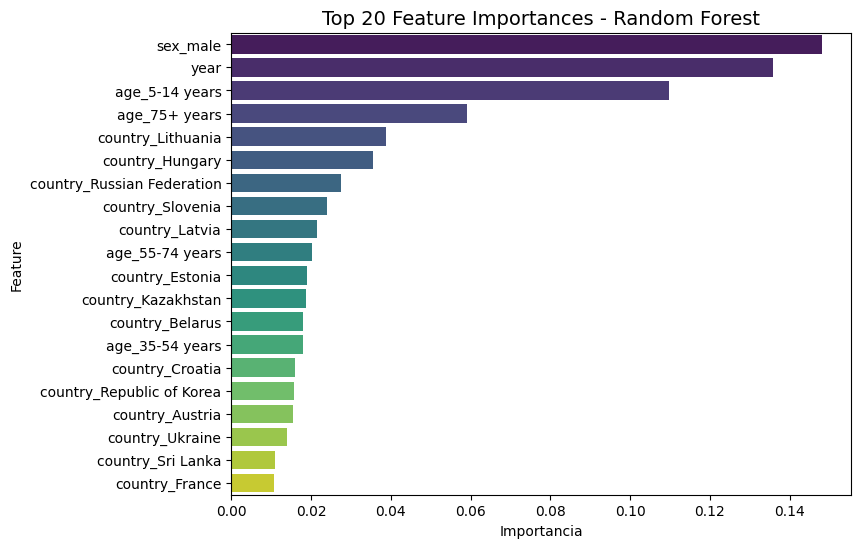

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Obtener importancias
feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns)

# Top 20 features más importantes
top_features = feat_imp.nlargest(20)

plt.figure(figsize=(8,6))
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
plt.title("Top 20 Feature Importances - Random Forest", fontsize=14)
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.show()




##  Interpretación de los resultados

1. **Sexo (`sex_male`)**

   * Es el factor más importante.
   * Confirma la evidencia epidemiológica: los hombres tienen tasas de suicidio consistentemente más altas.
   * El modelo lo usa como la primera división clave en muchos árboles.

2. **Año (`year`)**

   * También pesa mucho: hay una clara tendencia temporal (picos en los 80s-90s y caídas post-2000).
   * El modelo aprende que el riesgo ha cambiado a lo largo del tiempo.

3. **Edad (`age_5-14 years`, `age_75+ years`)**

   * Interesante: los extremos de edad aparecen como muy importantes.
   * Esto refleja que **niños/adolescentes** y **adultos mayores** tienen dinámicas muy diferentes en suicidios.

4. **Países específicos**

   * Lituania, Hungría, Rusia, Eslovenia, Letonia…
   * Todos son países que efectivamente aparecían en el **top global** en el EDA.
   * El modelo los usa como “señales” fuertes.

5. **Otros factores**

   * Resto de edades y países aparecen con importancia menor, pero aún aportan al modelo.

---

Qué conclusión parcial obtengo?

* Básicamente: *“ser hombre, en ciertos países de Europa del Este, y en ciertos años/edades, aumenta el riesgo”*.



Igualmente quiero seguir explorando. Para este caso voy a analizar errores y alguna validación extra. 



### Scatter real vs. predicho → detectar sesgos.

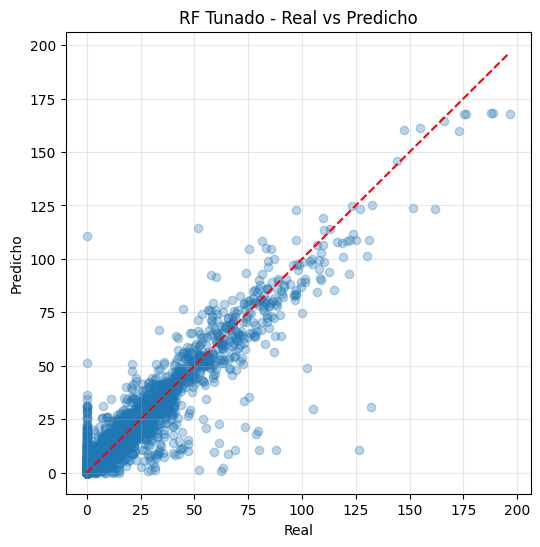

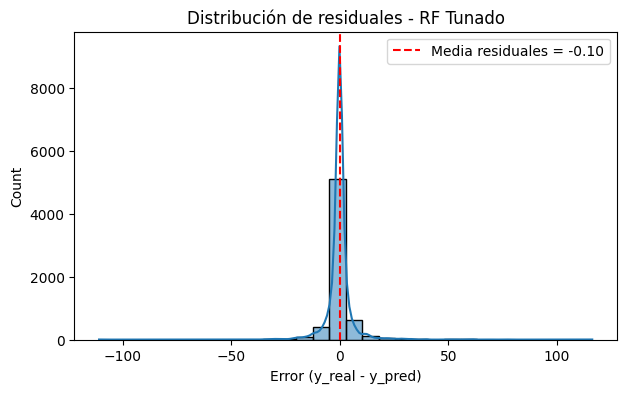

C:\Users\franco\AppData\Local\Temp\ipykernel_13348\964681861.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=err_country.values, y=err_country.index, palette="viridis")


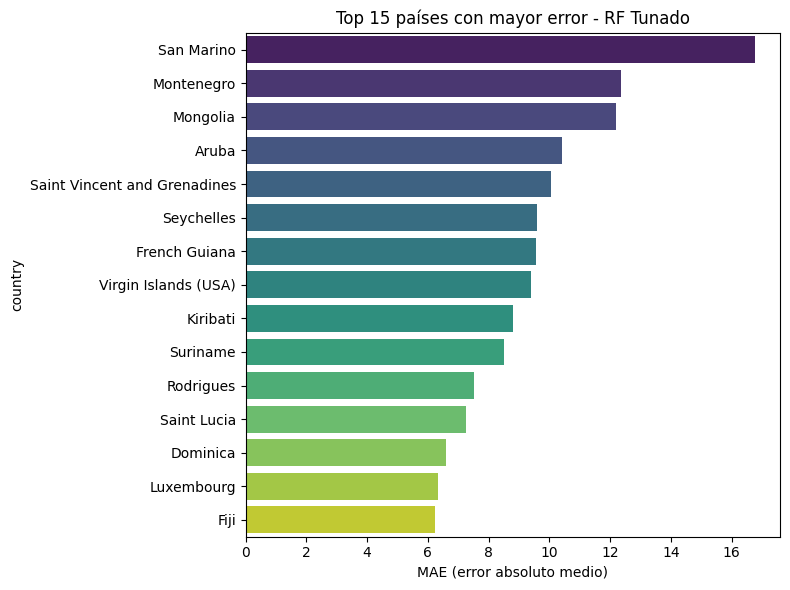

✅ Error analysis completo


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predicciones con el modelo tunado
y_pred = rf_final.predict(X_test)

# =====================
# 1. Scatter Real vs Predicho
# =====================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
m = max(y_test.max(), y_pred.max())
plt.plot([0, m], [0, m], 'r--')
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title("RF Tunado - Real vs Predicho")
plt.grid(alpha=0.3)
plt.show()

# =====================
# 2. Distribución de residuales
# =====================
residuales = y_test - y_pred

plt.figure(figsize=(7,4))
sns.histplot(residuales, bins=30, kde=True)
plt.axvline(residuales.mean(), color="r", linestyle="--", label=f"Media residuales = {residuales.mean():.2f}")
plt.xlabel("Error (y_real - y_pred)")
plt.title("Distribución de residuales - RF Tunado")
plt.legend()
plt.show()

# =====================
# 3. MAE por país
# =====================
# Recuperamos los índices del test para mapear al dataset original
test_idx = X_test.index
df_test = df.loc[test_idx, ["country", "year", "sex", "age"]].copy()
df_test["y_real"] = y_test.values
df_test["y_pred"] = y_pred
df_test["abs_error"] = (df_test["y_real"] - df_test["y_pred"]).abs()

# Top países con más error
err_country = df_test.groupby("country")["abs_error"].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x=err_country.values, y=err_country.index, palette="viridis")
plt.xlabel("MAE (error absoluto medio)")
plt.title("Top 15 países con mayor error - RF Tunado")
plt.tight_layout()
plt.show()

print("✅ Error analysis completo")



1. **Real vs. Predicho**

   * Vemos que la nube de puntos sigue bien la diagonal → el modelo captura la tendencia general.
   * Pero hay dispersión en valores altos (outliers de países con tasas extremas).

2. **Distribución de residuales**

   * La media está cerca de 0 (no sesgo fuerte).
   * Distribución concentrada, pero con colas largas → significa que algunos países/años son difíciles de predecir.

3. **Errores por país**

   * Aparecen **países pequeños o con datos irregulares (San Marino, Aruba, Dominica, etc.)** con alto error → esto es esperable porque tienen menos datos o poblaciones pequeñas → más variabilidad en las tasas.


### SHAP

In [ ]:
import shap

# Creamos el explicador
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Resumen global (importancia + dirección de impacto)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Más detallado: puntos que muestran cómo cada feature empuja hacia arriba/abajo
shap.summary_plot(shap_values, X_test)
